# DeepAR


In [ ]:
# Installation of gluonTS
!pip install --upgrade mxnet==1.6.0
!pip install gluonts==0.14.2
!pip uninstall numpy # Downgrade numpy to 1.23
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.1 MB/s eta 0:00:00
Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? 

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/My Drive/data/time_series'
# https://www.kaggle.com/datasets/yasserh/walmart-dataset
data = pd.read_csv(path + '/walmart.csv')
# convert string to datetime64
data["ds"] = pd.to_datetime(data["Date"])
data = data.sort_values(by=['Store','ds'])
data.tail()

<ipython-input-4-11bf9f919a40>:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data["ds"] = pd.to_datetime(data["Date"])


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,ds
6423,45,10-08-2012,733037.32,0,78.65,3.722,191.162613,8.684,2012-10-08
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,2012-10-19
6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667,2012-10-26
6410,45,11-05-2012,770487.37,0,61.24,3.889,190.976417,8.567,2012-11-05
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,2012-12-10


Text(0.5, 1.0, 'Walmart Weekly Sales of Store 1 - 10')

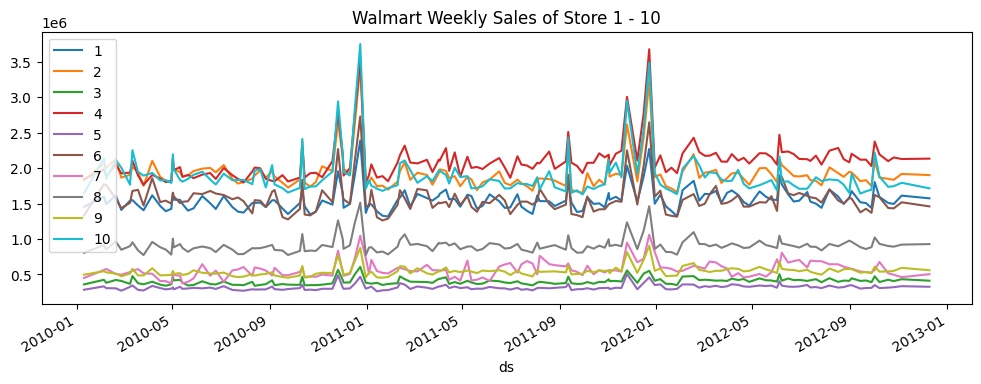

In [ ]:
# pivot the data into the correct shape
storewide = data.pivot(index='ds', columns='Store', values='Weekly_Sales')
some_stores = storewide.loc[:,1:10] # Plot only Store 1 - 10
# plot the pivoted dataframe
some_stores.plot(figsize=(12, 4))
plt.legend(loc='upper left')
plt.title("Walmart Weekly Sales of Store 1 - 10")

In [ ]:
print("The time series has", storewide.shape[0], "weeks")

The time series has 143 weeks


In [ ]:
len_train = int(storewide.shape[0] * 0.85)
train_data = storewide[0:len_train]
test_data = storewide[len_train:]
[train_data.shape, test_data.shape]

[(121, 45), (22, 45)]

## GluonTS data preparation

In [ ]:
# Prepare the data for deepAR format
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def to_deepar_format(dataframe, freq):
    start_index = dataframe.index.min()
    data = [{
                FieldName.START:  start_index,
                FieldName.TARGET:  dataframe[c].values,
            }
            for c in dataframe.columns]
    print(data[0])
    return ListDataset(data, freq=freq)
train_data_lds = to_deepar_format(train_data, 'W')
test_data_lds = to_deepar_format(test_data, 'W')

{'start': Timestamp('2010-01-10 00:00:00'), 'target': array([1453329.5 , 1594968.28, 1492418.14, 1611968.17, 1409727.59,
       1540163.53, 1548033.78, 1472515.79, 1404429.92, 1615524.71,
       1466058.28, 1391256.12, 1425100.71, 1643690.9 , 1554806.68,
       1551659.28, 1494251.5 , 1399662.07, 1432069.95, 1605491.78,
       1503284.06, 1422711.6 , 1603955.12, 1448938.92, 1385065.2 ,
       1371986.6 , 1508239.93, 1508237.76, 1513080.49, 1449142.92,
       1545418.53, 1546074.18, 1430378.67, 1351791.03, 1507460.69,
       1682614.26, 1459409.1 , 1345454.  , 1384209.22, 1542561.09,
       1483784.18, 1955624.11, 1641957.44, 1439541.59, 1494479.49,
       1891034.93, 2387950.2 , 1367320.01, 1495064.75, 1488538.09,
       1391013.96, 1327405.42, 1316899.31, 1550229.22, 1584083.95,
       1686842.78, 1456800.28, 1635078.41, 1576818.06, 1541102.38,
       1606629.58, 1636263.41, 1697229.58, 1559889.  , 1564819.81,
       1455090.69, 1624383.75, 1604775.58, 1428218.27, 1466046.67,
       1

DeepAR Basic Hyperparameters:

- prediction_length: How many steps the model is going to predict
- context_length: The number of time-points that the model gets to see before making the prediction. The value for this parameter should be about the same as the prediction_length.
- epochs: The maximum number of passes over the training data. Typical values range from 10 to 1000.
- num_cells: The number of cells to use in each hidden layer of the RNN. Typical values range from 30 to 100.
- num_layers: The number of hidden layers in the RNN. Typical values range from 1 to 4.

In [ ]:
# api: https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.model.deepar.html
# paper: Salinas, David, Valentin Flunkert, and Jan Gasthaus. “DeepAR: Probabilistic forecasting with autoregressive recurrent networks.” arXiv preprint arXiv:1704.04110 (2017).

from gluonts.mx.model.deepar import DeepAREstimator
#from gluonts.torch.model.deepar.estimator import DeepAREstimator
from gluonts.mx.trainer import Trainer

prediction_length = 11
context_length = 11
num_cells = 32
num_layers = 2
epochs= 5
freq="W" # Our data is weekly

estimator =   DeepAREstimator(freq=freq,
                                context_length=context_length,
                                prediction_length=prediction_length,
                                num_layers=num_layers,
                                num_cells=num_cells,
                                cardinality=[1],
                                trainer=Trainer(epochs=epochs))
predictor = estimator.train(train_data_lds)

100%|██████████| 50/50 [00:02<00:00, 20.18it/s, epoch=5/5, avg_epoch_loss=13]


In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data_lds,
    predictor=predictor,
)
tss = list(ts_it)
forecasts = list(forecast_it)

In [ ]:
for k in range(5): #len(forecasts)):
  fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
  forecasts[k].plot(ax = ax1)
  tss[k].plot(ax = ax1)
  ax1.get_legend().remove()
  plt.grid(which="both")
  plt.title("Store " + str(k) )
  plt.show()

NameError: name 'plt' is not defined

In [ ]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data_lds))

import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 45/45 [00:00<00:00, 1243.28it/s]


{
    "MSE": 8200494702.157576,
    "abs_error": 31120068.03125,
    "abs_target_sum": 508089357.75,
    "abs_target_mean": 1026443.1469696971,
    "seasonal_error": 58367.47604166667,
    "MASE": 1.2103036035084258,
    "MAPE": 0.06332899879927588,
    "sMAPE": 0.06257073337381538,
    "MSIS": 11.551944375348741,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 14576000.571875002,
    "Coverage[0.1]": 0.05656565656565656,
    "QuantileLoss[0.2]": 21643231.91875,
    "Coverage[0.2]": 0.19191919191919196,
    "QuantileLoss[0.3]": 26475546.018749997,
    "Coverage[0.3]": 0.3131313131313132,
    "QuantileLoss[0.4]": 29288500.993750002,
    "Coverage[0.4]": 0.4181818181818182,
    "QuantileLoss[0.5]": 31120067.96875,
    "Coverage[0.5]": 0.5414141414141413,
    "QuantileLoss[0.6]": 30791397.012500003,
    "Coverage[0.6]": 0.6303030303030304,
    "QuantileLoss[0.7]": 28879478.05,
    "Coverage[0.7]": 0.7575757575757575,
    "QuantileLoss[0.8]": 24599869.27499999,
    "Coverage[

## Monte Carlo simulation

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
orig = yf.download(["AAPL"], start="2020-01-01", end="2024-12-31")
orig = orig[('Adj Close')]
orig.tail()

[*********************100%%**********************]  1 of 1 completed


Date
2024-02-26    181.160004
2024-02-27    182.630005
2024-02-28    181.419998
2024-02-29    180.750000
2024-03-01    179.660004
Name: Adj Close, dtype: float64

<Axes: >

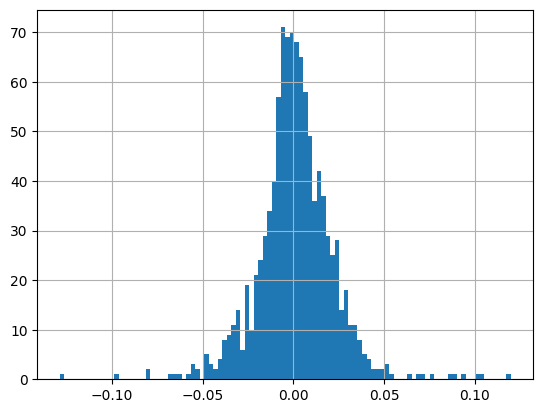

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
returns = orig.pct_change()
last_price = orig[-1]
returns.hist(bins=100)

In [18]:
daily_volatility = returns.std()
daily_volatility

0.020857025073480973

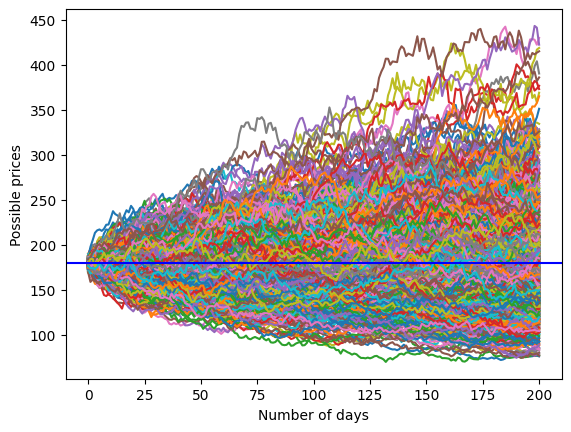

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

num_simulations = 1000
num_days = 200
simulation_df = pd.DataFrame()

for x in range(num_simulations):
    count = 0

    # The first price point
    price_series = []
    rtn = np.random.normal(0, daily_volatility)
    price = last_price * (1  + rtn)
    price_series.append(price)

    # Create each price path
    for g in range(num_days):
        rtn = np.random.normal(0, daily_volatility)
        price = price_series[g] * (1  + rtn)
        price_series.append(price)

    # Save all the possible price paths
    simulation_df[x] = price_series

fig = plt.figure()
plt.plot(simulation_df)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')
plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()

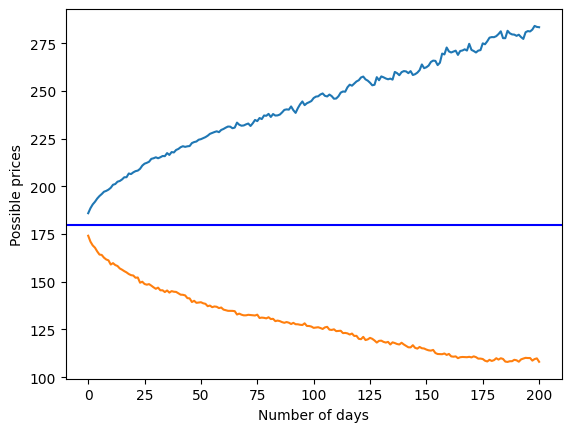

In [38]:
upper = simulation_df.quantile(.95, axis=1)
lower = simulation_df.quantile(.05, axis=1)
stock_range = pd.concat([upper, lower], axis=1)

fig = plt.figure()
plt.plot(stock_range)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')

plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()